In [21]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))


In [22]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']


In [23]:
def count_dependencies(rel_deps):
    return len(rel_deps)

def contains_dependency(dep, rel_deps):
    for dependency in rel_deps:
        if dep in dependency:
            return 1
    return 0

def get_unique_deps(rels_deps):
    unique_deps = set()
    for data_point in rels_deps:
        for dep in data_point:
            unique_deps.add(dep[0])
    return list(unique_deps)

p_data['num_deps'] = p_data['rel_deps'].apply(count_dependencies)

dep_types = get_unique_deps(p_data['rel_deps'])
for dep_type in dep_types:
    p_data[f'contains_{dep_type}'] = p_data['rel_deps'].apply(lambda x: contains_dependency(dep_type, x))

p_data2 = p_data[['rel_deps']].copy()
    
for dep_type in dep_types:
    p_data2[f'contains_{dep_type}'] = p_data['rel_deps'].apply(lambda x: contains_dependency(dep_type, x))


In [25]:
p_data['type'].value_counts()

vp-ing         41660
acc-ing         5954
ing-of          2982
det-ing         2959
poss-ing        1249
poss-ing-of      255
Name: type, dtype: int64

## Overall

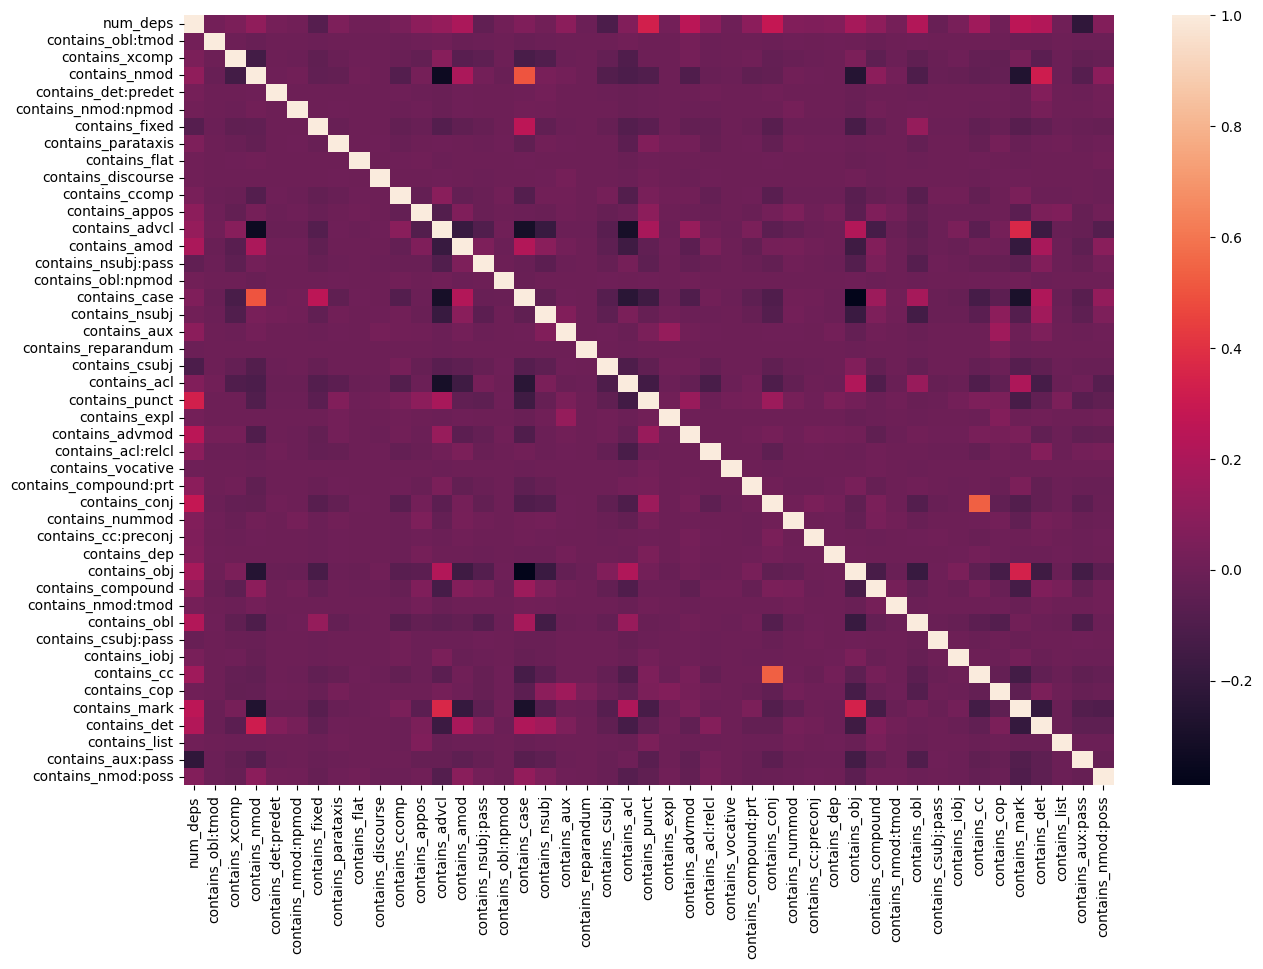

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(p_data.corr(),  ax=ax)

plt.show()

In [25]:
corr_matrix_overall = p_data2.corr()


In [30]:
top_correlations_pos = corr_matrix_overall.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)

top_correlations_neg = corr_matrix_overall.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)

In [31]:
top_positive_correlations

,level_0,level_1,0
1,contains_cc,contains_conj,0.536800
2,contains_nmod,contains_case,0.501393
3,contains_advcl,contains_mark,0.361703
4,contains_mark,contains_obj,0.342636
5,contains_det,contains_nmod,0.313333
6,contains_case,contains_fixed,0.251746
7,contains_obj,contains_advcl,0.224247
8,contains_amod,contains_case,0.220237
9,contains_obj,contains_acl,0.216382
10,contains_det,contains_case,0.208048


In [32]:
top_negative_correlations

,level_0,level_1,0
0,contains_case,contains_obj,-0.388704
1,contains_nmod,contains_advcl,-0.343850
2,contains_advcl,contains_acl,-0.304844
3,contains_advcl,contains_case,-0.304258
4,contains_mark,contains_case,-0.290590
5,contains_nmod,contains_mark,-0.268417
6,contains_obj,contains_nmod,-0.249812
7,contains_case,contains_acl,-0.234133
8,contains_det,contains_mark,-0.190133
9,contains_amod,contains_mark,-0.188222


## DEPENDENCY FUNCTION 

In [142]:
def get_dependency_correlations(df, dep_type):
    dep_data = df[df['type'] == dep_type].drop(['num_deps'], axis=1)
    corr_matrix = dep_data.corr()
    
    # Drop columns and rows that are completely null in the correlation matrix
    null_columns = corr_matrix.columns[corr_matrix.isnull().all()].tolist()
    corr_matrix.drop(null_columns, axis=1, inplace=True)
    corr_matrix.dropna(axis=0, how='all', inplace=True)
    
    top_correlations_pos = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
    top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
    top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)

    top_correlations_neg = corr_matrix.unstack().sort_values().drop_duplicates().reset_index()
    top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
    top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)

    print(top_positive_correlations)
    print(top_negative_correlations)

    # get sentences and their rel_deps for positive correlations
    pos_sentences = []
    for index, row in top_positive_correlations.iterrows():
        dep1 = row['level_0']
        dep2 = row['level_1']
        count = 0
        for sent in dep_data[dep_data[f'{dep1}'] == 1].index:
            if dep_data.loc[sent][f'{dep2}'] == 1:
                sentence = dep_data.loc[sent]['sentence']
                rel_deps = dep_data.loc[sent]['rel_deps']
                gerund = dep_data.loc[sent]['gerund']
                pos_sentences.append((dep1, dep2, sentence, rel_deps, gerund))
                count += 1
            if count == 2:
                break

    # get sentences and their rel_deps for negative correlations
    neg_sentences = []
    for index, row in top_negative_correlations.iterrows():
        dep1 = row['level_0']
        dep2 = row['level_1']
        count = 0
        for sent in dep_data[dep_data[f'{dep1}'] == 1].index:
            if dep_data.loc[sent][f'{dep2}'] == 1:
                sentence = dep_data.loc[sent]['sentence']
                rel_deps = dep_data.loc[sent]['rel_deps']
                gerund = dep_data.loc[sent]['gerund']
                neg_sentences.append((dep1, dep2, sentence, rel_deps, gerund))
                count += 1
            if count == 1:
                break
                
    return (pos_sentences, neg_sentences)


## acc-ing

In [175]:
accing = p_data[p_data['type'] == 'acc-ing']
corr_matrix_acc = accing.corr()
null_columns = corr_matrix_acc.columns[corr_matrix_acc.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)

corr_matrix_acc.drop(null_columns, axis=1, inplace=True)
corr_matrix_acc.dropna(axis=0, how='all', inplace=True)



Columns that are completely null in the correlation matrix: ['contains_det:predet', 'contains_reparandum', 'contains_det', 'contains_nmod:poss']


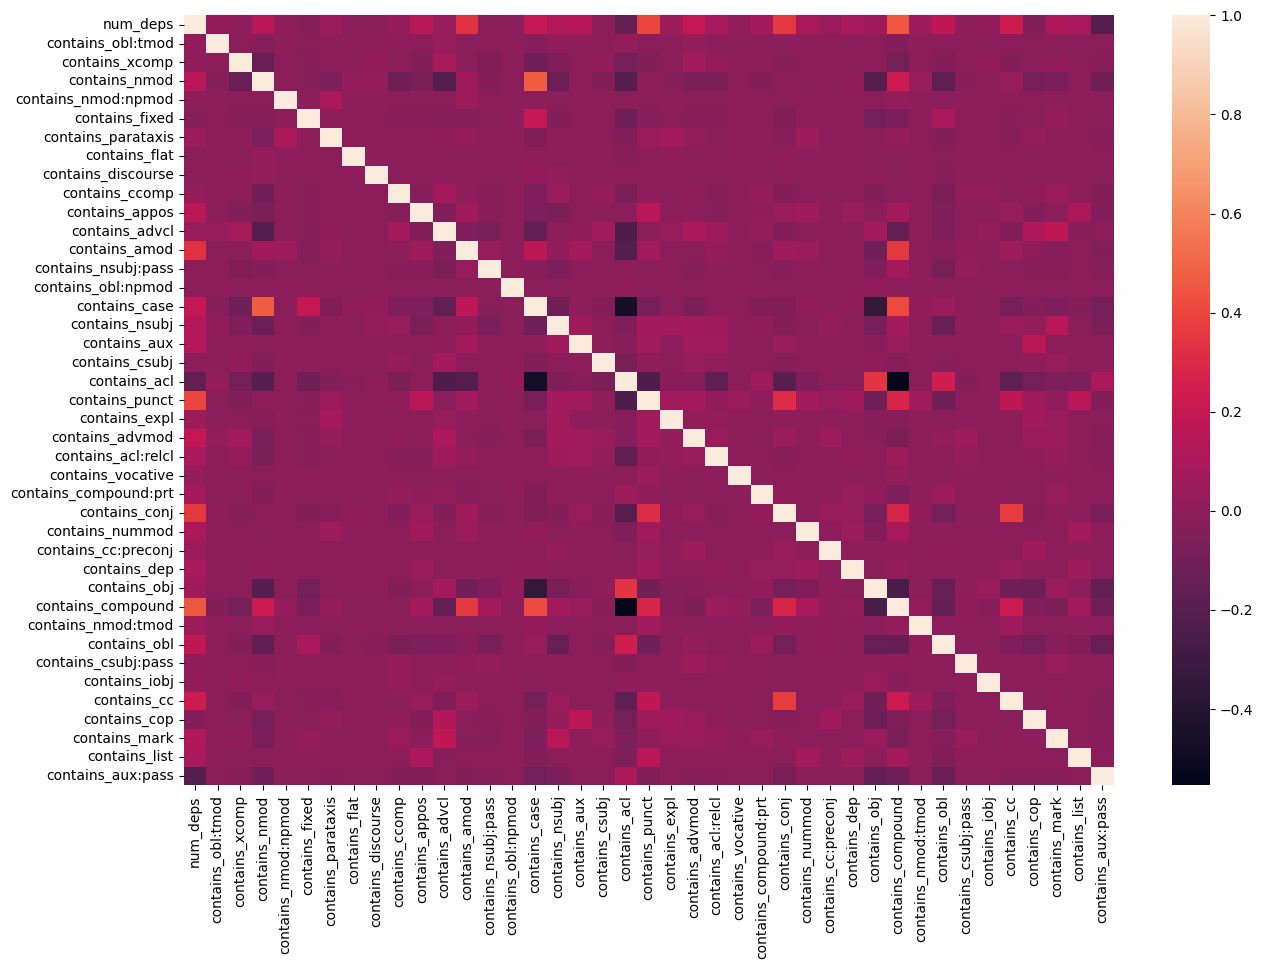

In [176]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_acc,  ax=ax)

plt.show()

In [145]:
pos_acc, neg_acc = get_dependency_correlations(p_data, "acc-ing")


              level_0            level_1         0
1       contains_nmod      contains_case  0.468654
2   contains_compound      contains_case  0.408600
3         contains_cc      contains_conj  0.372518
4       contains_amod  contains_compound  0.352204
5        contains_acl       contains_obj  0.341505
6      contains_punct      contains_conj  0.309532
7      contains_punct  contains_compound  0.279469
8   contains_compound      contains_conj  0.276907
9        contains_acl       contains_obl  0.242014
10        contains_cc  contains_compound  0.220795
          level_0            level_1         0
0    contains_acl  contains_compound -0.554402
1   contains_case       contains_acl -0.472789
2    contains_obj      contains_case -0.346010
3    contains_obj  contains_compound -0.255449
4    contains_acl     contains_punct -0.234254
5  contains_advcl       contains_acl -0.232861
6   contains_amod       contains_acl -0.217844
7   contains_nmod     contains_advcl -0.216601
8    contains_ob

## vp-ing

In [169]:
vping = p_data[p_data['type'] == 'vp-ing']
corr_matrix_vp = vping.corr()
null_columns = corr_matrix_vp.columns[corr_matrix_vp.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)

corr_matrix_vp.drop(null_columns, axis=1, inplace=True)
corr_matrix_vp.dropna(axis=0, how='all', inplace=True)



Columns that are completely null in the correlation matrix: ['contains_det:predet']


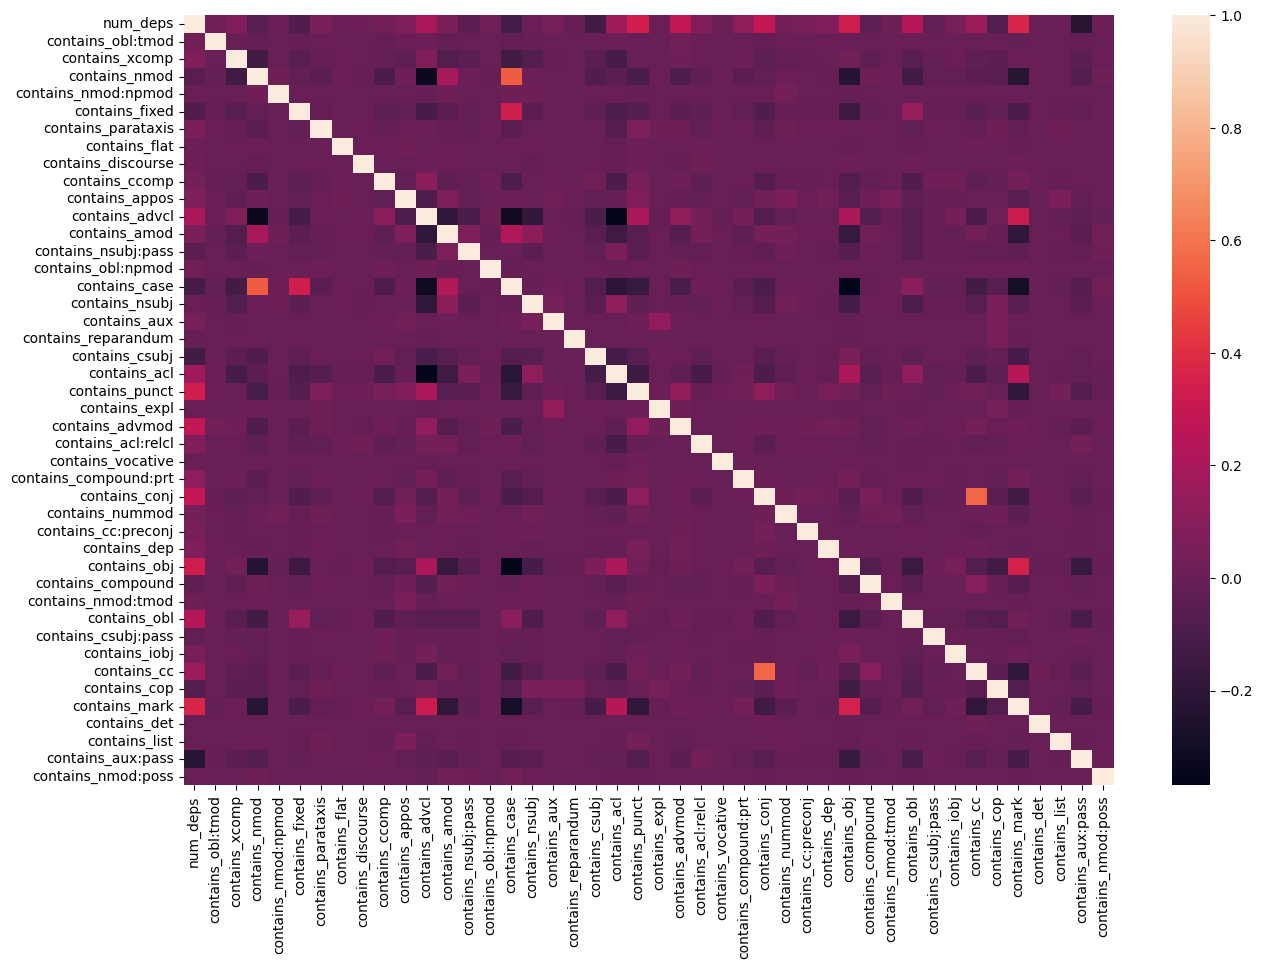

In [170]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_vp,  ax=ax)

plt.show()

In [148]:
pos_vp, neg_vp = get_dependency_correlations(p_data, "vp-ing")


           level_0         level_1         0
1      contains_cc   contains_conj  0.556833
2    contains_nmod   contains_case  0.533508
3    contains_mark    contains_obj  0.350490
4   contains_fixed   contains_case  0.332744
5    contains_mark  contains_advcl  0.316361
6    contains_mark    contains_acl  0.250561
7    contains_amod   contains_case  0.235406
8   contains_advcl    contains_obj  0.205143
9     contains_acl    contains_obj  0.204644
10  contains_advcl  contains_punct  0.201933
          level_0        level_1         0
0   contains_case   contains_obj -0.368618
1  contains_advcl   contains_acl -0.363499
2  contains_advcl  contains_nmod -0.335120
3  contains_advcl  contains_case -0.314719
4   contains_case  contains_mark -0.295683
5   contains_nmod   contains_obj -0.233984
6   contains_nmod  contains_mark -0.225761
7   contains_case   contains_acl -0.213352
8   contains_mark    contains_cc -0.196478
9   contains_mark  contains_amod -0.192163


## ing-of

In [117]:
ingof = p_data2[p_data2['type'] == 'ing-of']
corr_matrix_ing = ingof.corr()

null_columns = corr_matrix_ing.columns[corr_matrix_ing.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)

corr_matrix_ing.drop(null_columns, axis=1, inplace=True)
corr_matrix_ing.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_iobj', 'contains_aux:pass', 'contains_flat', 'contains_list', 'contains_nmod', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_compound:prt', 'contains_fixed', 'contains_nmod:poss', 'contains_obl:tmod']


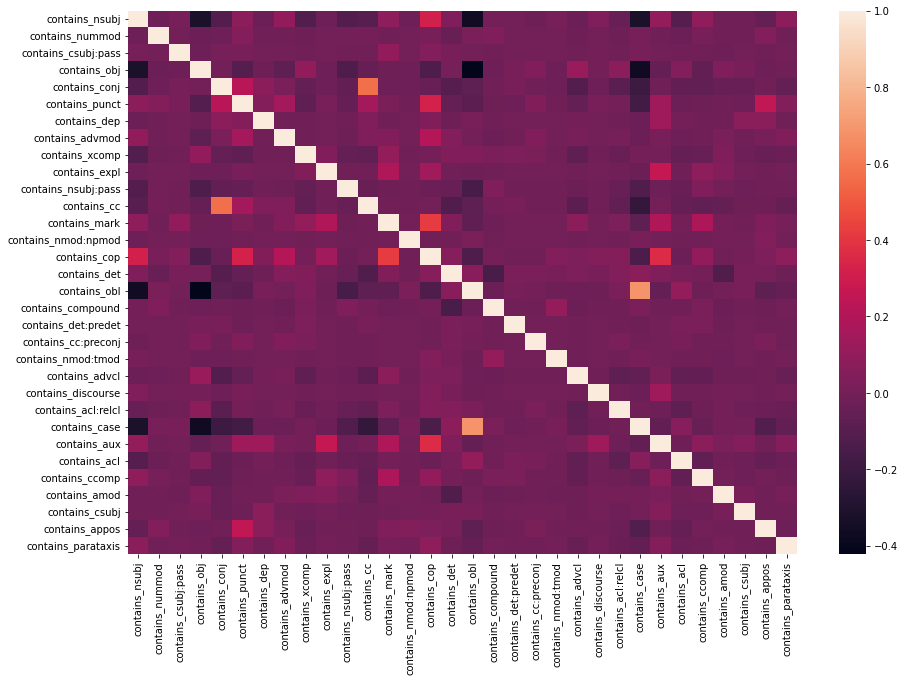

In [118]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_ing,  ax=ax)

plt.show()

In [151]:
pos_ing_of, neg_ing_of = get_dependency_correlations(p_data, "ing-of")


           level_0          level_1         0
1    contains_case     contains_obl  0.686145
2    contains_conj      contains_cc  0.571995
3     contains_cop    contains_mark  0.418950
4     contains_cop     contains_aux  0.365006
5     contains_cop   contains_punct  0.325024
6   contains_nsubj     contains_cop  0.320159
7    contains_expl     contains_aux  0.270655
8   contains_punct   contains_appos  0.253930
9   contains_punct    contains_conj  0.224185
10    contains_cop  contains_advmod  0.206940
               level_0         level_1         0
0         contains_obl    contains_obj -0.421824
1         contains_obj   contains_case -0.362250
2         contains_obl  contains_nsubj -0.357713
3       contains_nsubj    contains_obj -0.318937
4        contains_case  contains_nsubj -0.318769
5          contains_cc   contains_case -0.229443
6        contains_conj   contains_case -0.189880
7       contains_punct   contains_case -0.169910
8  contains_nsubj:pass    contains_obl -0.152933
9   

## det-ing

In [122]:
deting = p_data2[p_data2['type'] == 'det-ing']
corr_matrix_det = deting.corr()

null_columns = corr_matrix_det.columns[corr_matrix_det.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)


corr_matrix_det.drop(null_columns, axis=1, inplace=True)
corr_matrix_det.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_aux:pass', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_det', 'contains_discourse']


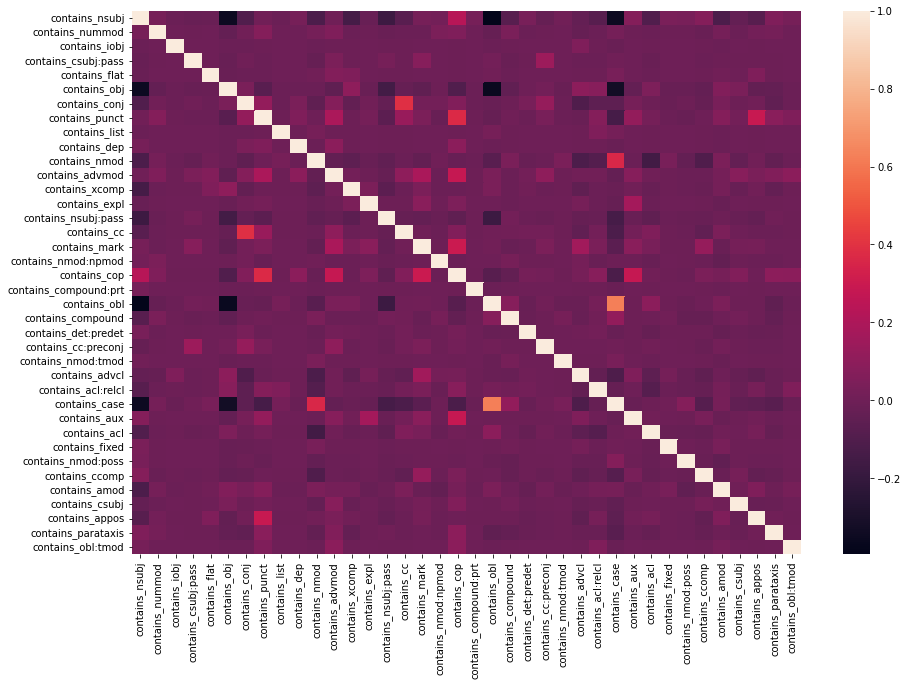

In [123]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_det,  ax=ax)

plt.show()

In [157]:
pos_det, neg_det = get_dependency_correlations(p_data, "det-ing")


           level_0          level_1         0
1    contains_case     contains_obl  0.628491
2    contains_conj      contains_cc  0.394200
3     contains_cop   contains_punct  0.372314
4    contains_case    contains_nmod  0.360835
5     contains_cop    contains_mark  0.301842
6   contains_punct   contains_appos  0.286061
7     contains_aux     contains_cop  0.281520
8     contains_cop  contains_advmod  0.280840
9     contains_cop   contains_nsubj  0.232230
10  contains_punct  contains_advmod  0.195143
               level_0              level_1         0
0       contains_nsubj         contains_obl -0.395921
1         contains_obj         contains_obl -0.358549
2         contains_obj       contains_nsubj -0.349646
3        contains_case       contains_nsubj -0.347701
4        contains_case         contains_obj -0.327609
5         contains_obl  contains_nsubj:pass -0.173116
6  contains_nsubj:pass       contains_nsubj -0.168142
7         contains_acl        contains_nmod -0.155530
8       

## poss-ing

In [127]:
possing = p_data2[p_data2['type'] == 'poss-ing']
corr_matrix_possing = possing.corr()

null_columns = corr_matrix_possing.columns[corr_matrix_possing.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)


corr_matrix_possing.drop(null_columns, axis=1, inplace=True)
corr_matrix_possing.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_iobj', 'contains_aux:pass', 'contains_list', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_compound:prt', 'contains_discourse', 'contains_fixed', 'contains_nmod:poss']


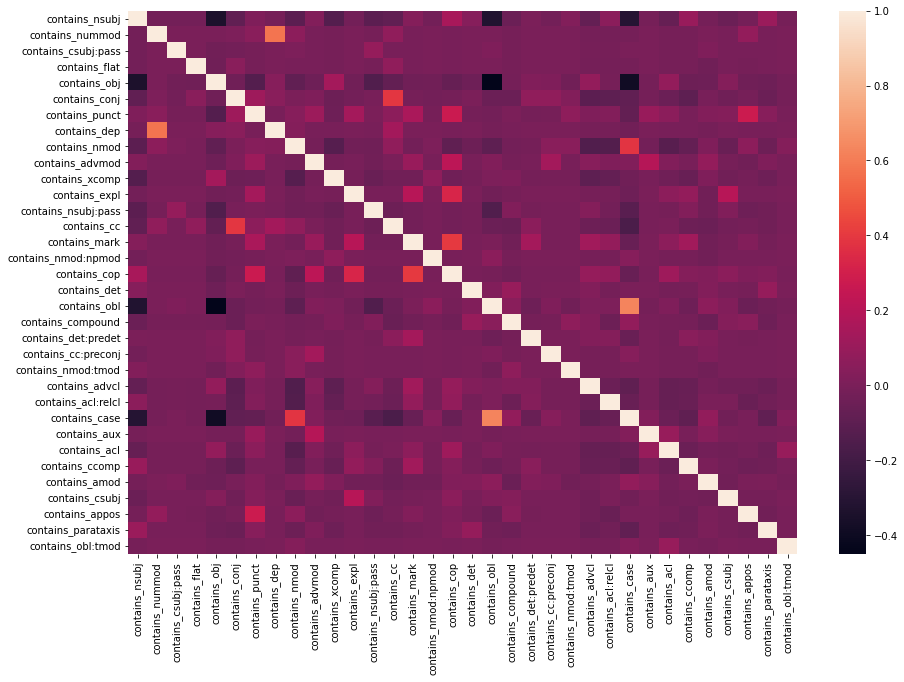

In [128]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_possing,  ax=ax)

plt.show()

In [163]:
pos_ing, neg_ing = get_dependency_correlations(p_data, "poss-ing")


           level_0          level_1         0
1     contains_obl    contains_case  0.626558
2     contains_dep  contains_nummod  0.576887
3    contains_mark     contains_cop  0.401302
4    contains_conj      contains_cc  0.390712
5    contains_case    contains_nmod  0.386257
6     contains_cop    contains_expl  0.331188
7   contains_punct   contains_appos  0.274886
8   contains_punct     contains_cop  0.274517
9     contains_cop  contains_advmod  0.222550
10  contains_csubj    contains_expl  0.201332
               level_0        level_1         0
0         contains_obj   contains_obl -0.450685
1        contains_case   contains_obj -0.388035
2       contains_nsubj   contains_obj -0.340079
3       contains_nsubj   contains_obl -0.325067
4       contains_nsubj  contains_case -0.306513
5          contains_cc  contains_case -0.165287
6  contains_nsubj:pass   contains_obj -0.143711
7       contains_advcl  contains_nmod -0.142641
8  contains_nsubj:pass   contains_obl -0.141102
9   contains_a

## poss-ing-of

In [132]:
possingof = p_data2[p_data2['type'] == 'poss-ing-of']
corr_matrix_possof = possingof.corr()

null_columns = corr_matrix_possof.columns[corr_matrix_possof.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)


corr_matrix_possof.drop(null_columns, axis=1, inplace=True)
corr_matrix_possof.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_iobj', 'contains_aux:pass', 'contains_csubj:pass', 'contains_flat', 'contains_list', 'contains_nmod', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_expl', 'contains_nmod:npmod', 'contains_compound:prt', 'contains_det:predet', 'contains_nmod:tmod', 'contains_discourse', 'contains_fixed', 'contains_nmod:poss', 'contains_obl:tmod']


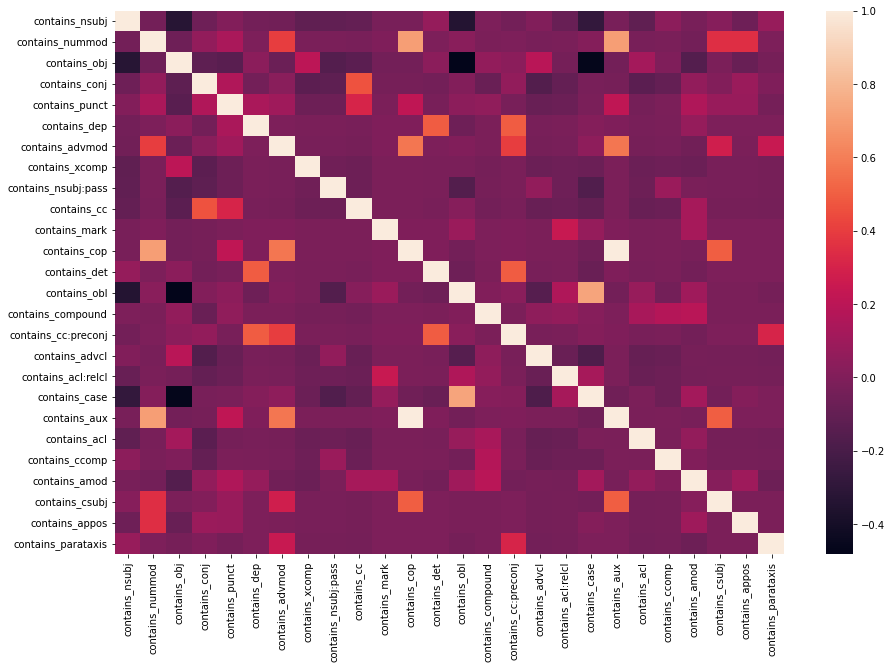

In [133]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_possof,  ax=ax)

plt.show()

In [166]:
pos_ing_of, neg_ing_of = get_dependency_correlations(p_data, "poss-ing-of")


                level_0              level_1         0
1          contains_obl        contains_case  0.731946
2       contains_nummod         contains_aux  0.705713
3          contains_cop      contains_advmod  0.575073
4        contains_csubj         contains_cop  0.497038
5          contains_det  contains_cc:preconj  0.496047
6   contains_cc:preconj         contains_dep  0.496047
7           contains_cc        contains_conj  0.462730
8       contains_advmod  contains_cc:preconj  0.402590
9       contains_nummod      contains_advmod  0.402590
10       contains_csubj      contains_nummod  0.346541
               level_0         level_1         0
0         contains_obl    contains_obj -0.482451
1        contains_case    contains_obj -0.468042
2       contains_nsubj    contains_obl -0.340503
3       contains_nsubj    contains_obj -0.328551
4        contains_case  contains_nsubj -0.284664
5       contains_advcl   contains_case -0.178888
6  contains_nsubj:pass   contains_case -0.169195
7  